# Jet transport in the simple pendulum

In this tutorial, which is inspired by an [example](https://docs.sciml.ai/TaylorIntegration/stable/pendulum/) in the documentation of the [TaylorIntegration.jl package](https://docs.sciml.ai/TaylorIntegration/stable/), we will be using the [variational equations](<./var_ode_sys.ipynb>) to propagate a small neighbourhood of initial conditions in the [simple pendulum](https://en.wikipedia.org/wiki/Pendulum). This technique is called "jet transport" in the original example, in heyoka.py we call it {ref}`evaluation of the Taylor map <taylor_map>`.

Let us begin with the formulation of the simple pendulum dynamics:

In [1]:
import heyoka as hy
dyn = hy.model.pendulum()

The {func}`~heyoka.model.pendulum()` function generates the dynamics with respect to the state variables ``x`` (representing the angle with respect to the vertical) and ``v`` (which is the time derivative of ``x``):

In [2]:
dyn

[(x, v), (v, -sin(x))]

We proceed then to the creation of a variational ODE system via the {class}`~heyoka.var_ode_sys` class:

In [3]:
vsys = hy.var_ode_sys(dyn, hy.var_args.vars, order=8)

Here we asked for the variational equations up to order 8 with respect to the initial conditions of all state variables.

Next, we set up initial conditions for ``x`` and ``v``:

In [4]:
# Initial conditions.
ic = [1.3, 0.0]

We are now ready to create a variational ODE integrator:

In [5]:
ta = hy.taylor_adaptive(vsys, ic, compact_mode=True)

We then proceed to define a small circular ring of displacements for the state variables ``x`` and ``v``. This ring, which will be centered around the initial conditions ``ic``, will represent the boundary of the neighbourhood in phase space that we will be propagating with the help of the variational equations:

In [6]:
import numpy as np
phi = np.linspace(0, 2*np.pi, 100)
r = 0.05

# Create the x and v displacements.
dxrng = r*np.cos(phi)
dvrng = r*np.sin(phi)

We can now proceed to the numerical integration of the variational ODE system. We will be integrating for a total of 6 libration periods of the pendulum, and we will be recording the state of the system (including the variational variables) 8 times per period:

In [7]:
# Compute the exact libration period of the pendulum
# via elliptic integrals.
from scipy.special import ellipk
T = 4*ellipk(np.sin(ic[0]/2)**2)

# Define a time grid over 6 periods, with
# 8 points per period.
tgrid = np.linspace(0, 6*T, 6*8+1)

# Run the numerical propagation.
res = ta.propagate_grid(tgrid)[-1]

We are now ready to compute and plot how the ring-shaped neighbourhood around the initial conditions ``ic`` evolves in time. In order to do so, we will be using the ``eval_taylor_map()`` method of the integrator class, as explained in the {ref}`Taylor map computation tutorial <taylor_map>`:

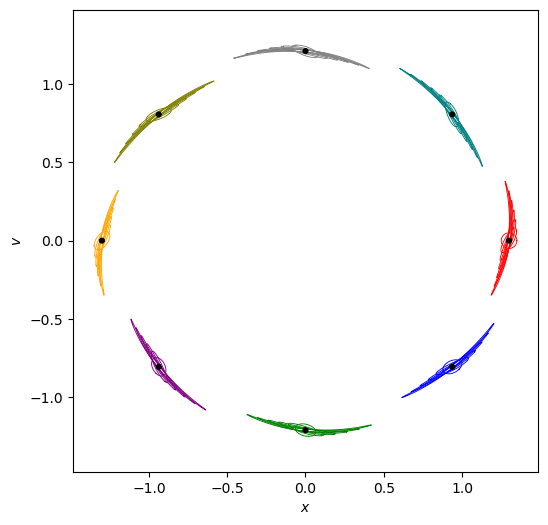

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(6, 6))
ax = fig.gca()
ax.axis('equal')

colors = ['red', 'blue', 'green', 'purple',
          'orange', 'olive', 'gray', 'teal']

# Iterate over the states of the system
# computed at the grid points.
for j, cur_state in enumerate(res):
    # Assign the current state vector,
    # so that we can later invoke
    # ta.eval_taylor_map().
    ta.state[:] = cur_state

    # Compute the current state of the
    # ring-shaped neighbourhood.
    x_map = []
    v_map = []
    for i in range(0, len(dxrng)):
        tmp = ta.eval_taylor_map([dxrng[i], dvrng[i]])
        x_map.append(tmp[0])
        v_map.append(tmp[1])

    # Plot it.
    color=colors[j % len(colors)]
    plt.plot(x_map, v_map, zorder=-1, color=color, lw=.65)

    # Plot the propagated state as a
    # black dot.
    if j >= 8:
        continue
    circle = plt.Circle((ta.state[0], ta.state[1]),
                        0.015, color='k')
    ax.add_patch(circle)

plt.xlabel(r'$x$')
plt.ylabel(r'$v$');

We can follow the evolution of the neighbourhood in phase space beginning with the red circular ring around the initial conditions ``[x=1.3, v=0]``. As the state of the system (represented by black dots) circulates counterclockwise, we can see the ring progressively turning into an oval and stretching out.